# Game of Thrones Script Generator

## Load Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import time
import json
import pprint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

## Load Data

In [2]:
# Data from https://www.kaggle.com/gunnvant/game-of-thrones-srt
DATA_FOLDER = "game-of-thrones-srt"
for f in (os.listdir(DATA_FOLDER)):
    print(f)

season7.json
season4.json
season5.json
season6.json
season1.json
season2.json
season3.json


In [6]:
data = ""

for jfile in (os.listdir(DATA_FOLDER)):
    jfile = os.path.join(DATA_FOLDER, jfile)
    if jfile.endswith('.json'):
        with open(jfile) as f:
            script_coll = json.load(f)

            for episode in script_coll:
                #print (episode)
                episode_coll = script_coll[episode]
                for dialogue in episode_coll:
                    #print(episode_coll[dialogue].split(' '))
                    data = data + episode_coll[dialogue] + "\n"

print ('Length of text: {} characters'.format(len(data)))
#print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

Length of text: 1515670 characters


In [7]:
# Take a look at the first 250 characters in text
print(data[:250])

♪ (PIANO PLAYING) ♪
(CHANTING CONTINUES)
I'm Meera Reed, daughter of Howland Reed.
This is Brandon Stark,
son of Ned Stark.
How do I know that's true?
You were at the Fist of the First Men.
You were at Hardhome.
You've seen the Army of the Dead.
You'


In [11]:
# The unique characters in the file
vocab = sorted(set(data))
print ('{} unique characters'.format(len(vocab)))

# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in data])
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

88 unique characters
{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  '&' :   5,
  "'" :   6,
  '(' :   7,
  ')' :   8,
  ',' :   9,
  '-' :  10,
  '.' :  11,
  '/' :  12,
  '0' :  13,
  '1' :  14,
  '2' :  15,
  '3' :  16,
  '4' :  17,
  '5' :  18,
  '6' :  19,
  ...
}


In [25]:
# Hyperparameters
vocab_size = len(vocab)
embedding_dim = 256
seq_length = 100
examples_per_epoch = len(data)//(seq_length+1)
trunc_type = 'post'
oov_tok = "<OOV>"
rnn_units = 1024
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EPOCHS=10

In [15]:
# Training data
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

# For each sequence, duplicate and shift it to form the input and 
# target text by using the map method to apply a simple function 
# to each batch:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)



dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [17]:
# Model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [22]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


In [23]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
model.compile(optimizer='adam', loss=loss)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           22528     
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_1 (Dense)              (64, None, 88)            90200     
Total params: 4,051,032
Trainable params: 4,051,032
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [26]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 234 steps
Epoch 1/10
234/234 [==============================] - 281s 1s/step - loss: 2.4819
Epoch 2/10
234/234 [==============================] - 282s 1s/step - loss: 1.7251
Epoch 3/10
234/234 [==============================] - 294s 1s/step - loss: 1.4545
Epoch 4/10
234/234 [==============================] - 295s 1s/step - loss: 1.3308
Epoch 5/10
234/234 [==============================] - 288s 1s/step - loss: 1.2621
Epoch 6/10
234/234 [==============================] - 307s 1s/step - loss: 1.2151
Epoch 7/10
234/234 [==============================] - 322s 1s/step - loss: 1.1774
Epoch 8/10
234/234 [==============================] - 323s 1s/step - loss: 1.1439
Epoch 9/10
234/234 [==============================] - 325s 1s/step - loss: 1.1130
Epoch 10/10
234/234 [==============================] - 325s 1s/step - loss: 1.0845


In [27]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            22528     
_________________________________________________________________
gru_2 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_2 (Dense)              (1, None, 88)             90200     
Total params: 4,051,032
Trainable params: 4,051,032
Non-trainable params: 0
_________________________________________________________________


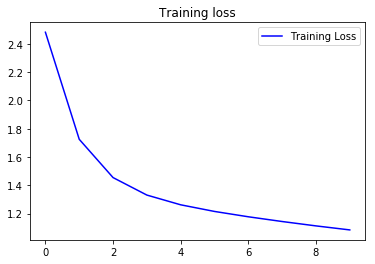

In [29]:
import matplotlib.pyplot as plt
#acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(loss))

#plt.plot(epochs, acc, 'b', label='Training accuracy')
#plt.title('Training accuracy')

#plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [30]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [31]:
seed_text = "And you will be his queen"
print(generate_text(model, start_string=seed_text))

seed_text = "May I"
print(generate_text(model, start_string=seed_text))

And you will be his queen and these food, slaughtered.
The king. Tell me, Non one.
To s Highgarden
to be faith watered.
Have you gone?
Alive?
Arya!
- Archers! - Mother, Daenerys do you want me to send us apart?
Where did they stay here.
I'll not look like this endine rains we're not a real servant of the Council, it sains.
Queen denent and keep with it once.
I'm not partn eyes to remarry the winder
Toward, but they're a man of the Veightep,
the First Mens have had a wame up from us.
Most of your heavily, is never had Qarth to ted the castle,
She gave you knops the dead.
My to manster we're going north.
- No, my lord, but de the Lannisters? it--
I told me that you work.
Now I know own your heart, fuck my heart
for provident to tell me.
I don't want to pars and shouldn't think it would be lealt the damn children
because their mouts into his chamoration by skills enough.
I ask queen of King's Landing old men to stop them,
let us going to be here.
The fire starving into the way to Casterly